In [1]:
import pyscf
import pyscf.qmmm
from pyscf import gto, scf
import numpy as np
import matplotlib.pyplot as plt
from pyscf.geomopt.berny_solver import optimize
from pyscf.grad import rhf as grhf
from pyscf.hessian import rhf as hrhf
from pyscf import lib
import inspect
from functools import reduce
from pyscf.scf import cphf
angstrom = 1 / 0.52917721067
from pyscf.scf._response_functions import _gen_rhf_response 
#mol_eq = optimize(mf)
#print(mol_eq.atom_coords())

In [2]:
def DeltaV(mol,dL):
    mol.set_rinv_orig_(mol.atom_coords()[0])
    dV=mol.intor('int1e_rinv')*dL[0]
    mol.set_rinv_orig_(mol.atom_coords()[1])
    dV+=mol.intor('int1e_rinv')*dL[1]
    return -dV

In [102]:
mol1 = gto.M(atom='H 0 0 0; H 0 0 1.199', unit="Bohr",basis="sto-3g")
mf1 = scf.RHF(mol1)
e1=mf1.scf()
mol = gto.M(atom='H 0 0 0; H 0 0 1.2', unit="Bohr",basis="sto-3g")
mf = scf.RHF(mol)
e=mf.scf()
mol2 = gto.M(atom='H 0 0 0; H 0 0 1.201', unit="Bohr",basis="sto-3g")
mf2 = scf.RHF(mol2)
e2=mf2.scf()

converged SCF energy = -1.11022683913526
converged SCF energy = -1.11033388268018
converged SCF energy = -1.11044001125658


In [103]:
def fc(calc,deltaZ):
    mf = pyscf.qmmm.mm_charge(calc, calc.mol.atom_coords(), deltaZ)  # now is add_mm_charge
    class NoSelfQMMM(mf.__class__):
        def energy_nuc(self):
            q = self.mol.atom_charges().astype(np.float).copy()
            q1 =q+ np.asarray(deltaZ) 
            return self.mol.energy_nuc(q1)
    return(NoSelfQMMM(mf,mf.mm_mol))

In [104]:
C=mf.mo_coeff
P=mf.make_rdm1()
O=np.diag(mf.mo_occ)
mo_coeff=mf.mo_coeff
mo_occ=mf.mo_occ
mo_energy=mf.mo_energy

In [105]:
mfa=fc(mf,[.01,-.01])
mfa.run()
P1=(mfa.make_rdm1()-P)
C1=(mfa.mo_coeff-C)/.01
C1

converged SCF energy = -1.11050145845196


array([[   0.78377375, -271.1741901 ],
       [  -0.78557085,  271.79596082]])

In [106]:
print('grad=', (e2-e1)/.002)
print('sec_deriv=',(e2+e1-2*e)/.001**2)

grad= -0.1065860606637159
sec_deriv= 0.914968513399117


In [107]:
print(hrhf.solve_mo1(mol,mf.mo_energy, mf.mo_coeff, mf.mo_occ,np.zeros((3,3)))[1])

converged SCF energy = -1.11033388268018
converged SCF energy = -1.11033388268018
[array([[[ 0.        ]],

       [[ 0.        ]],

       [[-0.01403631]]]), array([[[0.        ]],

       [[0.        ]],

       [[0.01403631]]])]


In [108]:
g = mf.Gradients()
g.kernel()
#print(lib.finger(g.kernel()) - -0.049887865971659243)

--------------- RHF gradients ---------------
         x                y                z
0 H     0.0000000000     0.0000000000     0.1065855689
1 H     0.0000000000     0.0000000000    -0.1065855689
----------------------------------------------


array([[ 0.        ,  0.        ,  0.10658557],
       [ 0.        ,  0.        , -0.10658557]])

In [109]:
hs=mf.Hessian()
hs.kernel()

array([[[[-0.08882131,  0.        ,  0.        ],
         [ 0.        , -0.08882131,  0.        ],
         [ 0.        ,  0.        ,  0.91496769]],

        [[ 0.08882131,  0.        ,  0.        ],
         [ 0.        ,  0.08882131,  0.        ],
         [ 0.        ,  0.        , -0.91496769]]],


       [[[ 0.08882131,  0.        ,  0.        ],
         [ 0.        ,  0.08882131,  0.        ],
         [ 0.        ,  0.        , -0.91496769]],

        [[-0.08882131,  0.        ,  0.        ],
         [ 0.        , -0.08882131,  0.        ],
         [ 0.        ,  0.        ,  0.91496769]]]])

In [110]:
hs.kernel()[0][0]

array([[-0.08882131,  0.        ,  0.        ],
       [ 0.        , -0.08882131,  0.        ],
       [ 0.        ,  0.        ,  0.91496769]])

Which methods are called by rhf.hessian and which by rhf.grad ?

In [111]:
hs.hess_nuc()+hs.hess_elec()

array([[[[-0.08882131,  0.        ,  0.        ],
         [ 0.        , -0.08882131,  0.        ],
         [ 0.        ,  0.        ,  0.91496769]],

        [[ 0.08882131,  0.        ,  0.        ],
         [ 0.        ,  0.08882131,  0.        ],
         [ 0.        ,  0.        , -0.91496769]]],


       [[[ 0.08882131,  0.        ,  0.        ],
         [ 0.        ,  0.08882131,  0.        ],
         [ 0.        ,  0.        , -0.91496769]],

        [[-0.08882131,  0.        ,  0.        ],
         [ 0.        , -0.08882131,  0.        ],
         [ 0.        ,  0.        ,  0.91496769]]]])

In [112]:
hs.hess_elec()

array([[[[ 0.4898824 ,  0.        ,  0.        ],
         [ 0.        ,  0.4898824 ,  0.        ],
         [ 0.        ,  0.        , -0.24243972]],

        [[-0.4898824 ,  0.        ,  0.        ],
         [ 0.        , -0.4898824 ,  0.        ],
         [ 0.        ,  0.        ,  0.24243972]]],


       [[[-0.4898824 ,  0.        ,  0.        ],
         [ 0.        , -0.4898824 ,  0.        ],
         [ 0.        ,  0.        ,  0.24243972]],

        [[ 0.4898824 ,  0.        ,  0.        ],
         [ 0.        ,  0.4898824 ,  0.        ],
         [ 0.        ,  0.        , -0.24243972]]]])

Hessian is divided in two part hess_elec()+hess_nuc()
<br>
<b> hess_elec() </b> calls  <b>solve_mo1() </b>, than <b>cphf.solve</b>(fx, mo_energy, mo_occ, h1vo, s1vo)

In [113]:
#fx is a function  fx(dm_mo) => v1_mo.  A function to generate the induced potential.
#also passes through  pyscf.scf._response_functions._gen_rhf_response
fx=pyscf.hessian.rhf.gen_vind(mf,mf.mo_coeff,mf.mo_occ)
#h1vo come from h1ao generated by the function: is a list with an element per each atom
h1ao=hs.make_h1(mf.mo_coeff,mf.mo_occ)
#s1ao comes from the espextation value of the nabla operator
s1ao=mol.intor('int1e_ipovlp', comp=3).shape        

In [114]:
#dm1 = numpy.einsum('ypi,qi->ypq', mo1[ja], mocc) #for every mo1[atom_idx]

In [115]:
nao, nmo = mo_coeff.shape
mocc = mo_coeff[:,mo_occ>0] 
nocc = mocc.shape[1]
vresp = _gen_rhf_response(mf, mo_coeff, mo_occ, hermi=1)

In [116]:
#hs.gen_vind(mf, mo_coeff, mo_occ):
"""nao, nmo = mo_coeff.shape
mocc = mo_coeff[:,mo_occ>0]
nocc = mocc.shape[1]
vresp = _gen_rhf_response(mf, mo_coeff, mo_occ, hermi=1)  ##############################
def fx(mo1):    
    mo1 = mo1.reshape(-1,nmo,nocc)
    nset = len(mo1)
    dm1 = np.empty((nset,nao,nao))
    for i, x in enumerate(mo1):
        dm = reduce(np.dot, (mo_coeff, x*2, mocc.T)) # *2 for double occupancy
        dm1[i] = dm + dm.T
    v1 = vresp(dm1)    # M.O.
    v1vo = np.empty_like(mo1)
    for i, x in enumerate(v1):
        v1vo[i] = reduce(np.dot, (mo_coeff.T, x, mocc))
    return v1vo"""

'nao, nmo = mo_coeff.shape\nmocc = mo_coeff[:,mo_occ>0]\nnocc = mocc.shape[1]\nvresp = _gen_rhf_response(mf, mo_coeff, mo_occ, hermi=1)  ##############################\ndef fx(mo1):    \n    mo1 = mo1.reshape(-1,nmo,nocc)\n    nset = len(mo1)\n    dm1 = np.empty((nset,nao,nao))\n    for i, x in enumerate(mo1):\n        dm = reduce(np.dot, (mo_coeff, x*2, mocc.T)) # *2 for double occupancy\n        dm1[i] = dm + dm.T\n    v1 = vresp(dm1)    # M.O.\n    v1vo = np.empty_like(mo1)\n    for i, x in enumerate(v1):\n        v1vo[i] = reduce(np.dot, (mo_coeff.T, x, mocc))\n    return v1vo'

In [117]:
mo1=P.copy()
mo1 = mo1.reshape(-1,nmo,nocc)
nset = len(mo1)
dm1 = np.empty((nset,nao,nao))
for i, x in enumerate(mo1):
    dm = reduce(np.dot, (mo_coeff, x*2, mocc.T)) # *2 for double occupancy
    dm1[i] = dm + dm.T
v1 = vresp(dm1)
v1

array([[[0.81969714, 0.50806081],
        [0.50806081, 0.94315408]],

       [[0.81969714, 0.50806081],
        [0.50806081, 0.94315408]]])

In [118]:
for i, x in enumerate(mo1):
    print(i,x)

0 [[0.57848631]
 [0.57848631]]
1 [[0.57848631]
 [0.57848631]]


In [119]:
vresp(P)

array([[0.76183791, 0.43912951],
       [0.43912951, 0.76183791]])

In [120]:
fx(P)

array([[[ 0.80379887],
        [-0.09012943]],

       [[ 0.80379887],
        [-0.09012943]]])

In [121]:
mf.get_veff()

array([[0.76183791, 0.43912951],
       [0.43912951, 0.76183791]])

In [122]:
C@mf.get_hcore()@C.T

array([[-4.13186739,  1.85496905],
       [ 1.85496905, -0.95965978]])

In [123]:
mf.Hessian().make_h1(mf.mo_coeff,mf.mo_occ)

[array([[[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],
 
        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],
 
        [[-0.21158437, -0.18574562],
         [-0.18574562, -0.21158437]]]), array([[[0.        , 0.        ],
         [0.        , 0.        ]],
 
        [[0.        , 0.        ],
         [0.        , 0.        ]],
 
        [[0.21158437, 0.18574562],
         [0.18574562, 0.21158437]]])]

In [124]:
mol.intor('int1e_ipovlp', comp=3).shape  # nabla operator

(3, 2, 2)

In [125]:
hs=mf.Hessian()
hs.solve_mo1(mf.mo_energy ,mf.mo_coeff,mf.mo_occ, hs.make_h1(mf.mo_coeff,mf.mo_occ))[1]

[array([[[ 0.        ]],
 
        [[ 0.        ]],
 
        [[-0.24388626]]]), array([[[0.        ]],
 
        [[0.        ]],
 
        [[0.24388626]]])]

In [126]:
DeltaV(mol,[1,-1])

array([[-0.49905405, -0.        ],
       [-0.        ,  0.49905405]])

In [127]:
mf.mo_energy ,mf.mo_coeff

(array([-0.624462  ,  0.79184861]), array([[ 0.53781331,  1.35743672],
        [ 0.53781331, -1.35743672]]))

In [128]:
e_a = mo_energy[mo_occ<=0]
e_i = mo_energy[mo_occ>0] 
e_ai = 1 / lib.direct_sum('a-i->ai', e_a, e_i)
e_ai,e_a,e_i

(array([[0.70605981]]), array([0.79184861]), array([-0.624462]))

In [129]:
C[mo_occ<=0,:]@DeltaV(mol,[.01,-.01])@(C[mo_occ>0,:]).T

array([[-0.01063922]])

In [163]:
C@DeltaV(mol,[.01,-.01])@(C.T)

array([[ 0.00775226, -0.01063922],
       [-0.01063922,  0.00775226]])

In [161]:
#hs.solve_mo1(mf.mo_energy ,mf.mo_coeff,mf.mo_occ, DeltaV(mol,[1,-1]))
dC=cphf.solve_nos1(fx, mf.mo_energy ,mf.mo_occ, (C@DeltaV(mol,[.01,-.01])@C.T@mo_occ).T)[0]
dC

ValueError: non-broadcastable output operand with shape (2,) doesn't match the broadcast shape (1,2)

In [146]:
dC=cphf.solve_nos1(fx, mf.mo_energy ,mf.mo_occ, C@DeltaV(mol,[.01,-.01])@(C.T) [mo_occ==0][mo_occ>0])[0]
dC

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 2

In [133]:
help(pyscf.lib.direct_sum)

Help on function direct_sum in module pyscf.lib.numpy_helper:

direct_sum(subscripts, *operands)
    Apply the summation over many operands with the einsum fashion.
    
    Examples:
    
    >>> a = numpy.random.random((6,5))
    >>> b = numpy.random.random((4,3,2))
    >>> direct_sum('ij,klm->ijklm', a, b).shape
    (6, 5, 4, 3, 2)
    >>> direct_sum('ij,klm', a, b).shape
    (6, 5, 4, 3, 2)
    >>> direct_sum('i,j,klm->mjlik', a[0], a[:,0], b).shape
    (2, 6, 3, 5, 4)
    >>> direct_sum('ij-klm->ijklm', a, b).shape
    (6, 5, 4, 3, 2)
    >>> direct_sum('ij+klm', a, b).shape
    (6, 5, 4, 3, 2)
    >>> direct_sum('-i-j+klm->mjlik', a[0], a[:,0], b).shape
    (2, 6, 3, 5, 4)
    >>> c = numpy.random((3,5))
    >>> z = direct_sum('ik+jk->kij', a, c).shape  # This is slow
    >>> abs(a.T.reshape(5,6,1) + c.reshape(5,1,3) - z).sum()
    0.0



In [134]:
e_a = mo_energy[mo_occ==0]
e_i = mo_energy[mo_occ>0]
e_ai = 1 / lib.direct_sum('a-i->ai', e_a, e_i)
e_a,e_i,e_ai

(array([0.79184861]), array([-0.624462]), array([[0.70605981]]))

In [143]:
mo_occ

array([2., 0.])

In [135]:
h1=hs.make_h1(mf.mo_coeff,mf.mo_occ)

In [136]:
dm1=np.einsum('ypi,qi->ypq',[dC],mocc)
dm1

array([[[ 0.00305342,  0.00305342],
        [-0.00126829, -0.00126829]]])

In [137]:
#de2[i0,j0] += 
#np.einsum('xpq,ypq->xy',DeltaV(mol,[.01,-.01]), dm1) * 4 #simile eq. 17 zachara e co.
np.trace(DeltaV(mol,[.01,-.01]).dot(dm1[0])) * 4/.01**2

-0.8627073149998932

In [138]:
mfa.e_tot,mfb.e_tot,mf.e_tot

(-1.1105014584519632, -1.1186164349233907, -1.1103338826801763)

In [139]:
dl=.003
mfb=fc(mf,[-dl,dl])
mfb.run()
(mfb.e_tot-mf.e_tot)/dl**2*2

converged SCF energy = -1.11034896467033


-3.351553367034496

In [140]:
mfb.energy_nuc(),mf.energy_nuc(),mfa.energy_nuc()

(0.8333258333333333, 0.8333333333333334, 0.83325)

In [141]:
(1.0001*.9999) /1.2

0.833333325

converged SCF energy = -2.63177551899436
converged SCF energy = -2.11290381790639
converged SCF energy = -1.68953023434824
converged SCF energy = -1.37339026749979
converged SCF energy = -1.17703581258726
converged SCF energy = -1.11033388268018
converged SCF energy = -1.17703581258726
converged SCF energy = -1.37339026749979
converged SCF energy = -1.68953023434824
converged SCF energy = -2.11290381790639
converged SCF energy = -2.63177551899436


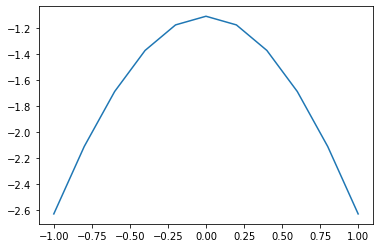

In [142]:
xp=np.linspace(-1,1,11)
yp=[]
for dl in xp:
    yp.append(fc(mf,[dl,-dl]).kernel())
plt.plot(xp,yp)